<a href="https://colab.research.google.com/github/Ecological-Complexity-Lab/link_prediction_project/blob/main/MLmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

In [41]:
df_mandena = pd.read_csv('/content/drive/MyDrive/LinkPredictionProject/Data/ML_rattus_mandena.csv', encoding='latin1')
df_mandena.head()

,host_ID,asv_ID,Link,grid,pca_grid_attr,pca_grid_sm,season,elevation.obs,mass,sex,...,host_degree,host_betweenness,host_closeness,host_module,asv_degree,asv_betweenness,asv_closeness,asv_module,shortest_path,pref_attach
0,2010,ASV_1,1,brushy_regrowth,-0.197466,-2.224026,1,144.218796,80.0,female,...,12,0.003539,0.003651,1,129,0.050775,0.003051,1,1,1548
1,2011,ASV_1,1,brushy_regrowth,-0.197466,-2.224026,1,145.284958,51.0,male,...,13,0.002761,0.003479,1,129,0.050775,0.003051,1,1,1677
2,2013,ASV_1,0,brushy_regrowth,-0.197466,-2.224026,1,118.188316,88.0,female,...,18,0.004112,0.003691,1,129,0.050775,0.003051,1,3,2322
3,2014,ASV_1,1,brushy_regrowth,-0.197466,-2.224026,1,133.551437,77.0,male,...,20,0.004784,0.003758,1,129,0.050775,0.003051,1,1,2580
4,2015,ASV_1,1,brushy_regrowth,-0.197466,-2.224026,1,145.232788,65.0,female,...,6,0.004310,0.003472,1,129,0.050775,0.003051,1,1,774


## Data preprocessing

In [42]:
df_mandena_filtered = df_mandena[["asv_ID", "asv_degree", "grid", "season", "elevation.obs", "host_degree", "mass", "sex", "Link"]]
df_mandena_filtered.head()

,asv_ID,asv_degree,grid,season,elevation.obs,host_degree,mass,sex,Link
0,ASV_1,129,brushy_regrowth,1,144.218796,12,80.0,female,1
1,ASV_1,129,brushy_regrowth,1,145.284958,13,51.0,male,1
2,ASV_1,129,brushy_regrowth,1,118.188316,18,88.0,female,0
3,ASV_1,129,brushy_regrowth,1,133.551437,20,77.0,male,1
4,ASV_1,129,brushy_regrowth,1,145.232788,6,65.0,female,1


In [43]:
# Convert "sex" column to numeric
df_mandena_filtered.loc[:, "sex"] = df_mandena_filtered["sex"].map({"female": 0, "male": 1})
# Scale "mass", "asv_degree", "elevation.obs" and "host_degree" columns
scaler = StandardScaler()
df_mandena_filtered.loc[:, "mass"] = scaler.fit_transform(df_mandena_filtered[["mass"]])
df_mandena_filtered.loc[:, "asv_degree"] = scaler.fit_transform(df_mandena_filtered[["asv_degree"]])
df_mandena_filtered.loc[:, "elevation.obs"] = scaler.fit_transform(df_mandena_filtered[["elevation.obs"]])
df_mandena_filtered.loc[:, "host_degree"] = scaler.fit_transform(df_mandena_filtered[["host_degree"]])

# Get dummies for "grid" column
df_mandena_filtered = pd.get_dummies(df_mandena_filtered, columns=["grid"], dtype="int", drop_first=True)
df_mandena_filtered.head()

,asv_ID,asv_degree,season,elevation.obs,host_degree,mass,sex,Link,grid_agroforest,grid_brushy_regrowth,grid_flooded_rice,grid_secondary_forest,grid_semi-intact_forest
0,ASV_1,8.179624,1,0.320651,-0.474878,-0.155948,0,1,0,1,0,0,0
1,ASV_1,8.179624,1,0.349677,-0.279223,-0.960616,1,1,0,1,0,0,0
2,ASV_1,8.179624,1,-0.388006,0.699053,0.066029,0,0,0,1,0,0,0
3,ASV_1,8.179624,1,0.030242,1.090363,-0.239190,1,1,0,1,0,0,0
4,ASV_1,8.179624,1,0.348256,-1.648809,-0.572156,0,1,0,1,0,0,0


## Choosing a model

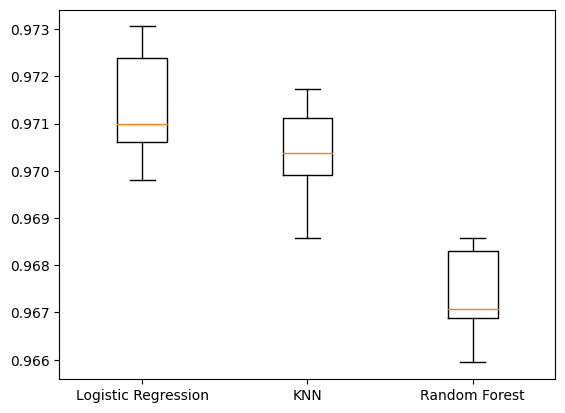

In [44]:
X = df_mandena_filtered.drop(["Link", "asv_ID"], axis=1)
y = df_mandena_filtered["Link"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
models = {
  "Logistic Regression": LogisticRegression(),
  "KNN": KNeighborsClassifier(),
  "Random Forest": RandomForestClassifier()
}
results = []

for model in models.values():
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  cv_results = cross_val_score(model, X_train, y_train, cv=kf)
  results.append(cv_results)

plt.boxplot(results, labels=models.keys())
plt.show()

In [45]:
for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  cr = classification_report(y_test, y_pred)

  print("The name of the model:", name)
  print("Accuracy on test set:", accuracy)
  print("Confusion Matrix:\n", cm)
  print("Classification Report:\n", cr)

The name of the model: Logistic Regression
Accuracy on test set: 0.9724109125283036
Confusion Matrix:
 [[44118   117]
 [ 1138   116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     44235
           1       0.50      0.09      0.16      1254

    accuracy                           0.97     45489
   macro avg       0.74      0.54      0.57     45489
weighted avg       0.96      0.97      0.96     45489

The name of the model: KNN
Accuracy on test set: 0.9711138956670844
Confusion Matrix:
 [[44098   137]
 [ 1177    77]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     44235
           1       0.36      0.06      0.10      1254

    accuracy                           0.97     45489
   macro avg       0.67      0.53      0.55     45489
weighted avg       0.96      0.97      0.96     45489

The name of the model: Random Forest
Accuracy 

In [46]:
# train model on all data
knn = KNeighborsClassifier(n_neighbors=9, p=1, weights="uniform")
knn.fit(X, y)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Accuracy on test set:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

# do the same with logistic regression
lr = LogisticRegression()
lr.fit(X, y)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Accuracy on test set:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

Accuracy on test set: 0.9733342126667985
Confusion Matrix:
 [[44180    55]
 [ 1158    96]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     44235
           1       0.64      0.08      0.14      1254

    accuracy                           0.97     45489
   macro avg       0.81      0.54      0.56     45489
weighted avg       0.97      0.97      0.96     45489

Accuracy on test set: 0.9725428125480885
Confusion Matrix:
 [[44124   111]
 [ 1138   116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     44235
           1       0.51      0.09      0.16      1254

    accuracy                           0.97     45489
   macro avg       0.74      0.54      0.57     45489
weighted avg       0.96      0.97      0.96     45489



Training on all data, didn't improve the model predictions

In [47]:
#count link 1
df_mandena_filtered["Link"].value_counts()

Link
0    147374
1      4256
Name: count, dtype: int64

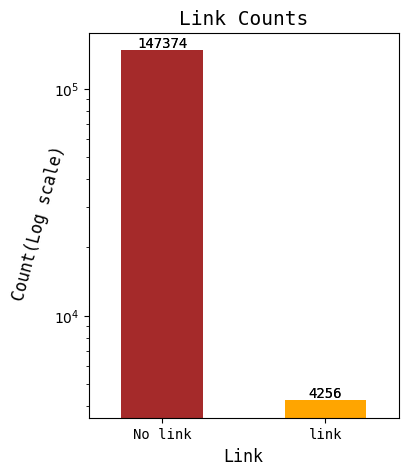

In [48]:
link_counts = df_mandena_filtered["Link"].value_counts()
plt.figure(figsize=(4,5))
link_counts.plot(kind="bar", color=['brown', 'orange'])
bars = link_counts.plot(kind="bar", color=['brown', 'orange'], width=0.4)
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{int(bar.get_height())}',
             ha='center',
             va='bottom',
             fontsize=10,
             fontname='monospace')

plt.yscale("log")
plt.title("Link Counts", name='monospace', fontsize=14)
plt.xlabel("Link", fontname='monospace', fontsize=12)
plt.ylabel("Count(Log scale)", fontsize=12, fontname='monospace', rotation=75)
plt.xticks([0,1], labels=["No link", "link"], rotation=0, fontsize=10, fontname='monospace')
plt.show()


we can conclude that the model is not good at predicting links beacause of the imbalanced data

In [57]:
# undersampling to balance the data
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_resampled, y_X_resampled = rus.fit_resample(X_train, y_train)
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_X_resampled, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=9, p=1, weights="uniform")
knn.fit(X_train_resampled, y_train_resampled)
y_pred_resampled = knn.predict(X_test_resampled)
accuracy = accuracy_score(y_test_resampled, y_pred_resampled)
cm = confusion_matrix(y_test_resampled, y_pred_resampled)
cr = classification_report(y_test_resampled, y_pred_resampled)
print("KNN")
print("Accuracy on test set:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

lr = LogisticRegression()
lr.fit(X_train_resampled, y_train_resampled)
y_pred_resampled = lr.predict(X_test_resampled)
accuracy = accuracy_score(y_test_resampled, y_pred_resampled)
cm = confusion_matrix(y_test_resampled, y_pred_resampled)
cr = classification_report(y_test_resampled, y_pred_resampled)
print("Logistic Regression")
print("Accuracy on test set:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

KNN
Accuracy on test set: 0.6542730299667037
Confusion Matrix:
 [[686 256]
 [367 493]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69       942
           1       0.66      0.57      0.61       860

    accuracy                           0.65      1802
   macro avg       0.65      0.65      0.65      1802
weighted avg       0.65      0.65      0.65      1802

Logistic Regression
Accuracy on test set: 0.7192008879023307
Confusion Matrix:
 [[761 181]
 [325 535]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75       942
           1       0.75      0.62      0.68       860

    accuracy                           0.72      1802
   macro avg       0.72      0.71      0.71      1802
weighted avg       0.72      0.72      0.72      1802



In [50]:
# perform grid search
grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}
gs = GridSearchCV(KNeighborsClassifier(), grid, cv=5)
gs.fit(X_train_resampled, y_train_resampled)
print("Best score:", gs.best_score_, "Best params:", gs.best_params_)

Best score: 0.6796761225298681 Best params: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


In [51]:
# perform random search
rs = RandomizedSearchCV(KNeighborsClassifier(), grid, cv=5)
rs.fit(X_train_resampled, y_train_resampled)
print("Best score:", rs.best_score_, "Best params:", rs.best_params_)

Best score: 0.6796761225298681 Best params: {'weights': 'uniform', 'p': 2, 'n_neighbors': 9}


In [52]:
# Based on the best parameters, create the model
knn = KNeighborsClassifier(n_neighbors=9, p=1, weights="uniform")
knn.fit(X_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test_resampled)
accuracy = accuracy_score(y_test_resampled, y_pred)
cm = confusion_matrix(y_test_resampled, y_pred)
cr = classification_report(y_test_resampled, y_pred)

print("Accuracy on test set:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)

Accuracy on test set: 0.6542730299667037
Confusion Matrix:
 [[686 256]
 [367 493]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69       942
           1       0.66      0.57      0.61       860

    accuracy                           0.65      1802
   macro avg       0.65      0.65      0.65      1802
weighted avg       0.65      0.65      0.65      1802



Feature 0: 0.13784683684794674
Feature 1: -0.018479467258601556
Feature 2: -0.019866814650388455
Feature 3: 0.009933407325194243
Feature 4: -0.02197558268590454
Feature 5: -0.019311875693673673
Feature 6: -0.006270810210876765
Feature 7: -0.005826859045504973
Feature 8: -0.007491675915649254
Feature 9: -0.0023862375138735013
Feature 10: 5.549389567147678e-05


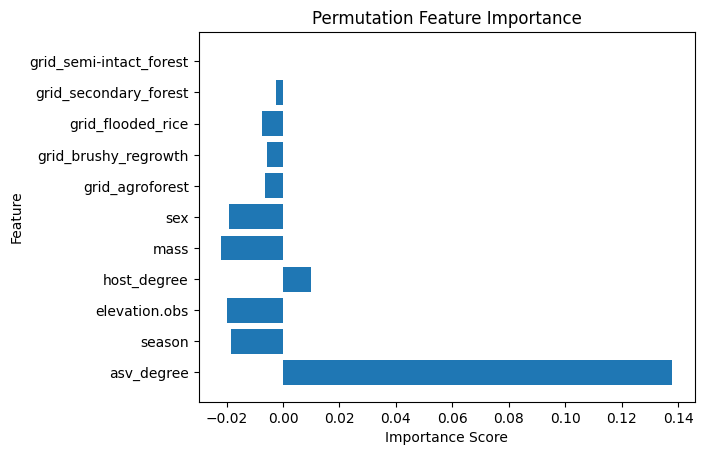

In [56]:
from sklearn.inspection import permutation_importance

lr = LogisticRegression()
lr.fit(X_train_resampled, y_train_resampled)

# Calculate permutation feature importance
result = permutation_importance(knn, X_test_resampled, y_test_resampled, n_repeats=10, random_state=42, n_jobs=-1)

# Get feature importance scores
importance_scores = result.importances_mean
feature_names = X_train_resampled.columns

# Plot feature importance scores
plt.barh(feature_names, importance_scores)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.show()


In [54]:
!pip install shap

After undersampling the data and hyperparameters tuning the predictions improved significally

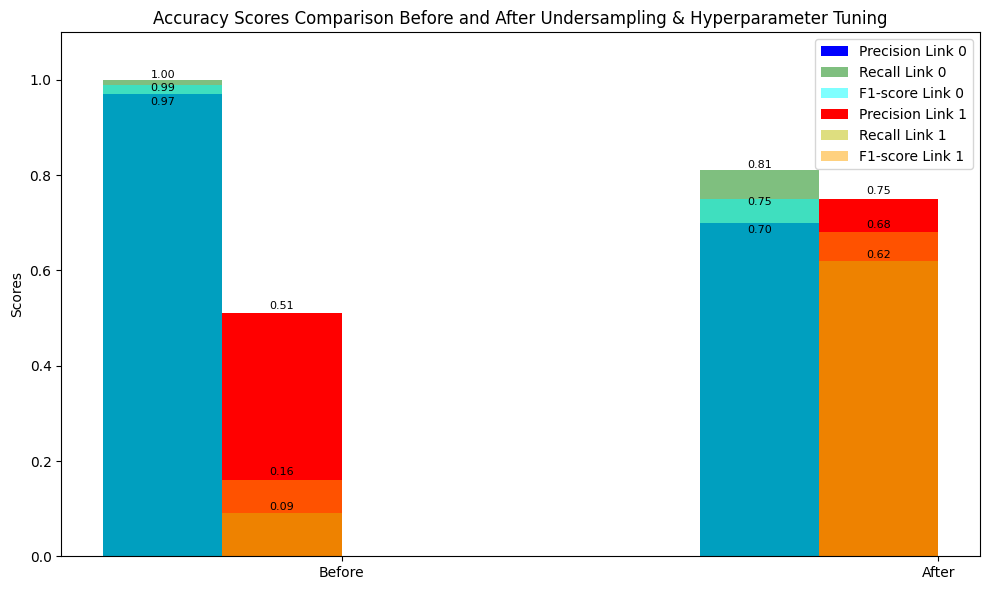

In [55]:
# Precision, Recall, and F1-score values
labels = ['Before', 'After']
precision_0 = [0.97, 0.70]
recall_0 = [1.00, 0.81]
f1_score_0 = [0.99, 0.75]
precision_1 = [0.51, 0.75]
recall_1 = [0.09, 0.62]
f1_score_1 = [0.16, 0.68]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
prec0 = ax.bar(x - 3*width/2, precision_0, width, label='Precision Link 0', color='b')
rec0 = ax.bar(x - 3*width/2, recall_0, width, label='Recall Link 0', color='g', alpha=0.5)
f10 = ax.bar(x - 3*width/2, f1_score_0, width, label='F1-score Link 0', color='cyan', alpha=0.5)

prec1 = ax.bar(x - width/2, precision_1, width, label='Precision Link 1', color='r')
rec1 = ax.bar(x - width/2, recall_1, width, label='Recall Link 1', color='y', alpha=0.5)
f11 = ax.bar(x - width/2, f1_score_1, width, label='F1-score Link 1', color='orange', alpha=0.5)

ax.set_ylabel('Scores')
ax.set_title('Accuracy Scores Comparison Before and After Undersampling & Hyperparameter Tuning')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects, offset):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, offset),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(prec0, -9)
autolabel(rec0, 0)
autolabel(f10, -6)
autolabel(prec1, 2)
autolabel(rec1, 1)
autolabel(f11, 2)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()